## 修改记录

#### 截止7.19 
- 利用预训练模型实现迁移学习
- 问题：
  1. 训练集准确率小于测试集
  2. 没有实现随机划分
- 解决方案：
  1. 交叉验证，看下是否还是训练精度低于测试精度；
  2. 随机选择数据作为测试集；
  3. 去掉0-30度的数据看下实验效果；
  4. 查找一下是否有解决dropout局限性的方法；
  5. 整理算法的框架图及伪代码


#### 7.20
- 尝试实现训练集和测试集的随机划分，以及K折交叉验证
- 问题：
  1. 一开始采用pytoch的包完成数据读取，预处理和分块；
  2. 在利用ImageFolder生成dataset后 没有现有函数对其进行transform（因为训练集和测试集采用不同的方法transform）
  3. pytorch没有现成API实现交叉验证
- 解决方案：
  1. 考虑采用sklearn完成数据的处理，但还没找到合适的transform 方法
  2. 随机划分可以使用pytorch的  
  torch.utils.data.random_split 或者  
  sklearn.model_selection.train_test_split
  3. 使用 KFold 进行K折划分
  4. 重写训练函数，K折交叉验证参考：  
  https://blog.csdn.net/foneone/article/details/104445320  ；
  https://blog.csdn.net/Pl_Sun/article/details/106975414


#### 7.21

## 依赖包
<!-- **Author**: `zwy` -->


In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
import copy

import random
import shutil

plt.ion()   # 交互模式可以动态显示图像

### 硬件选择 GPU / TPU

In [2]:
# GPU
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


## 数据加载及处理


### 下载数据集
可以从Google Drive / Github / 其他数据地址下载数据

In [ ]:
!rm -rf CNN
!git clone https://github.com/Zwysun/CNN.git
!ls

### 数据预处理
利用transforms对图片进行预处理，可以分别针对训练集和验证集采取不同的处理方法


In [3]:
# 直接加载数据集

# 训练集 扩充及正则化
# 验证集 仅正则化
# data_transforms = {
#   'train': transforms.Compose([
#     # transforms.Grayscale(1),      # 转换为灰度图
#     transforms.CenterCrop(1080),
#     transforms.RandomResizedCrop(224),
#     transforms.RandomHorizontalFlip(),    # 增广
#     transforms.ToTensor(),
#     # transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])    # RGB标准化参数(Imagenet Dateset)
#     transforms.Normalize([0.1307], [0.3081])      # 灰度图标准化参数(Mnist)
#     ]),
#   'val': transforms.Compose([
#     # transforms.Grayscale(1),
#     transforms.CenterCrop(1080),
#     transforms.Resize(224),
#     transforms.ToTensor(),
#     # transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
#     transforms.Normalize([0.1307], [0.3081])      # 灰度图标准化参数
#     ]),
# }
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

trainset = datasets.CIFAR10('/content/CIFAR10/', train=True, transform=data_transforms['train'], download=True)
valset = datasets.CIFAR10('/content/CIFAR10/', train=False, transform=data_transforms['val'], download=True)
image_datasets = {'train':trainset,'val':valset}
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], 
          batch_size=64, shuffle=True, num_workers=4)
              for x in ['train', 'val']}
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val']}
class_names = image_datasets['train'].classes
print (dataset_sizes)
print (image_datasets)
print (class_names)

Extracting /content/CIFAR10/cifar-10-python.tar.gz to /content/CIFAR10/
Files already downloaded and verified
{'train': 50000, 'val': 10000}
{'train': Dataset CIFAR10
    Number of datapoints: 50000
    Root location: /content/CIFAR10/
    Split: Train
    StandardTransform
Transform: Compose(
               RandomResizedCrop(size=(224, 224), scale=(0.08, 1.0), ratio=(0.75, 1.3333), interpolation=PIL.Image.BILINEAR)
               RandomHorizontalFlip(p=0.5)
               ToTensor()
               Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
           ), 'val': Dataset CIFAR10
    Number of datapoints: 10000
    Root location: /content/CIFAR10/
    Split: Test
    StandardTransform
Transform: Compose(
               Resize(size=256, interpolation=PIL.Image.BILINEAR)
               CenterCrop(size=(224, 224))
               ToTensor()
               Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
           )}
['airplane', 'automobile', 'bird', 'ca

### 显示部分图片


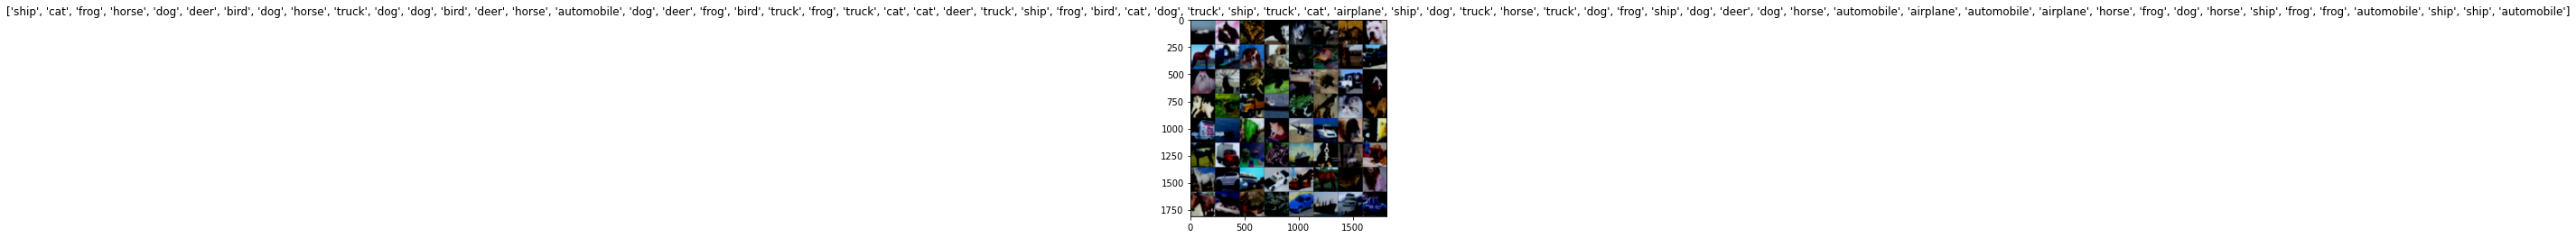

In [4]:
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    # mean = np.array([0.485, 0.456, 0.406])
    # std = np.array([0.229, 0.224, 0.225])   # RGB
    mean = np.array([0.1307])
    std = np.array([0.3081])   # 灰度图
    
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated

# Get a batch of training data
inputs, classes = next(iter(dataloaders['val']))

# Make a grid from batch
out = torchvision.utils.make_grid(inputs)

imshow(out, title=[class_names[x] for x in classes])

## 模型训练

In [7]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode 注意设置

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))

            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())
            if phase == 'train':
                scheduler.step()

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model

## 搭建网络结构

In [5]:
model_ft = models.densenet169(pretrained=True)
num_ftrs = model_ft.classifier.in_features
model_ft.classifier = nn.Linear(num_ftrs, 10, bias=True)  # 输出参数修改

# num_ochannels = model_ft.features.conv0.out_channels
# model_ft.features.conv0 = nn.Conv2d(1, num_ochannels, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False) # 输入参数修改

model_ft = model_ft.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)
# print (model_ft)

Downloading: "https://download.pytorch.org/models/densenet169-b2777c0a.pth" to /root/.cache/torch/hub/checkpoints/densenet169-b2777c0a.pth


In [ ]:
# 可视化网络
!pip install tensorwatch
import tensorwatch as tw


In [ ]:
tw.draw_model(model_ft, [1, 1, 224, 224])  # 有问题

In [ ]:
# 可视化工具
https://lutzroeder.github.io/netron/

## 训练

In [8]:
model_ft = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler, num_epochs=10)

Epoch 0/9
----------
train Loss: 0.8176 Acc: 0.7225
val Loss: 0.1897 Acc: 0.9357

Epoch 1/9
----------
train Loss: 0.4941 Acc: 0.8290
val Loss: 0.1456 Acc: 0.9509

Epoch 2/9
----------
train Loss: 0.4350 Acc: 0.8506
val Loss: 0.1295 Acc: 0.9565

Epoch 3/9
----------
train Loss: 0.3974 Acc: 0.8622
val Loss: 0.1189 Acc: 0.9606

Epoch 4/9
----------
train Loss: 0.3756 Acc: 0.8703
val Loss: 0.1164 Acc: 0.9611

Epoch 5/9
----------
train Loss: 0.3547 Acc: 0.8763
val Loss: 0.1164 Acc: 0.9616

Epoch 6/9
----------
train Loss: 0.3385 Acc: 0.8824
val Loss: 0.0997 Acc: 0.9691

Epoch 7/9
----------
train Loss: 0.3075 Acc: 0.8939
val Loss: 0.0897 Acc: 0.9708

Epoch 8/9
----------
train Loss: 0.2916 Acc: 0.9012
val Loss: 0.0903 Acc: 0.9704

Epoch 9/9
----------
train Loss: 0.2861 Acc: 0.9006
val Loss: 0.0887 Acc: 0.9724

Training complete in 62m 54s
Best val Acc: 0.972400


### 测试和保存

In [ ]:
from google.colab import drive
drive.mount('/content/drive')   # 挂载云盘

In [9]:
os.chdir("/content")
torch.save(model_ft,'CIFAR.pth')
!ls

CIFAR10  CIFAR.pth  sample_data


In [ ]:
os.chdir("/content/drive/My Drive")
!ls
torch.save(model_ft,'light.pth')

'2020 年日历.gsheet'  'Colab Notebooks'   light.pth  'Science Journal'


测试一下

In [ ]:
# 训练集 扩充及正则化
# 验证集 仅正则化
data_dir = 'CNN/dataset/morning'    # 数据目录
!rm -rf CNN/dataset/morning/train
!rm -rf CNN/dataset/morning/val
data_transforms = transforms.Compose([
        transforms.Grayscale(1),
        transforms.CenterCrop(1080),
        transforms.Resize(224),
        transforms.ToTensor(),
        # transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
        transforms.Normalize([0.1307], [0.3081])      # 灰度图标准化参数
    ])

test_datasets = datasets.ImageFolder(data_dir, data_transforms)
test_dataloaders = torch.utils.data.DataLoader(test_datasets, batch_size=4, shuffle=True, num_workers=4)

dataset_sizes = len(test_datasets)
class_names = test_datasets.classes
print (dataset_sizes)
print (test_datasets)
print (class_names)

190
Dataset ImageFolder
    Number of datapoints: 190
    Root location: CNN/dataset/morning
    StandardTransform
Transform: Compose(
               Grayscale(num_output_channels=1)
               CenterCrop(size=(1080, 1080))
               Resize(size=224, interpolation=PIL.Image.BILINEAR)
               ToTensor()
               Normalize(mean=[0.1307], std=[0.3081])
           )
['0', '10', '15', '20', '25', '30', '35', '40', '45', '5', '50', '55', '60', '65', '70', '75', '80', '85', '90']


In [ ]:
test_dataloaders=dataloaders['val']

In [ ]:
#show acc
model = torch.load('light.pth')
eval_loss = 0.
eval_acc = 0.
s= 0.
with torch.no_grad():
        for i, (inputs, labels) in enumerate(test_dataloaders):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            for j in range(inputs.size()[0]):
                #s =s + int(class_names[preds[j]])
                #print(class_names[preds[j]])
                #if int(class_names[preds[j]]) == int(labels[j]):
                if class_names[preds[j]] == class_names[int(labels[j])]:
                    s = s+1
print (s)
print (s/(len(test_dataloaders) * 4))